In [8]:
from typing import List, Literal
from typing_extensions import TypedDict
from langchain.prompts import PromptTemplate
from langchain.schema import Document
from langchain.text_splitter import RecursiveCharacterTextSplitter
from langchain_core.output_parsers import StrOutputParser
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.tools import tool
from langchain_core.prompts import ChatPromptTemplate
from langchain_community.document_loaders import WebBaseLoader
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_community.vectorstores import SKLearnVectorStore

from langgraph.graph import END, StateGraph
from langchain_groq import ChatGroq



In [9]:
### LLM
model = "llama-3.3-70b-versatile"
groq_api_key = "Your Groq api key"
llm = ChatGroq(model_name=model, temperature=0,api_key=groq_api_key)


### Web search

In [11]:
import os

# Set the API key as an environment variable
os.environ["TAVILY_API_KEY"] = "your tavily api key"


web_search_tool = TavilySearchResults(tavily_api_key=os.environ["TAVILY_API_KEY"],k=3)

In [12]:

# List of URLs to load documents from
urls = [
    "https://github.com/Pavansomisetty21/A-Fine-Tuned-Model-for-Medical-Named-Entity-Recognition-using-Gemini-LLM",
    "https://github.com/Pavansomisetty21/RAG-based-Intelligent-Conversational-AI-Agent-for-Knowledge-Extraction-Using-LangChain-Gemini-LLM",
    "https://github.com/Pavansomisetty21/Visual-Question-Answering-using-Gemini-LLM",
]

In [16]:
# Load documents from the URLs
docs = [WebBaseLoader(url).load() for url in urls]
docs_list = [item for sublist in docs for item in sublist]

# Initialize a text splitter with specified chunk size and overlap

text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=250, chunk_overlap=0
)

In [17]:
# Split the documents into chunks
doc_splits = text_splitter.split_documents(docs_list)

In [21]:
from langchain.embeddings import HuggingFaceEmbeddings
from langchain.vectorstores import Chroma

# Load a Hugging Face embedding model
embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")

# Create the vector store
vectorstore = Chroma.from_documents(documents=doc_splits, embedding=embedding_model)

# Use retriever
retriever = vectorstore.as_retriever(k=4)


<ipython-input-21-66ec7e325414>:5: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embedding_model = HuggingFaceEmbeddings(model_name="sentence-transformers/all-MiniLM-L6-v2")


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md:   0%|          | 0.00/10.5k [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

### RAG Chain

In [45]:


prompt = PromptTemplate(
    template="""You are an assistant for question-answering tasks.

    Use the following documents to answer the question.

    If you don't know the answer, just say that you don't know.

    Use three sentences maximum and keep the answer concise:
    Question: {question}
    Documents: {documents}
    Answer:
    """,
    input_variables=["question", "documents"],
)

rag_chain = prompt | llm | StrOutputParser()


In [24]:

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        question: question
        generation: LLM generation
        search: whether to add search
        documents: list of documents
    """

    question: str
    generation: str
    search: str
    documents: List[str]
    steps: List[str]


def retrieve(state):
    """
    Retrieve documents

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, documents, that contains retrieved documents
    """
    question = state["question"]
    documents = retriever.invoke(question)
    steps = state["steps"]
    steps.append("retrieve_documents")
    return {"documents": documents, "question": question, "steps": steps}


def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """

    question = state["question"]
    documents = state["documents"]
    generation = rag_chain.invoke({"documents": documents, "question": question})
    steps = state["steps"]
    steps.append("generate_answer")
    return {
        "documents": documents,
        "question": question,
        "generation": generation,
        "steps": steps,
    }


def grade_documents(state):
    """
    Determines whether the retrieved documents are relevant to the question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with only filtered relevant documents
    """

    question = state["question"]
    documents = state["documents"]
    steps = state["steps"]
    steps.append("grade_document_retrieval")
    filtered_docs = []
    search = "No"
    for d in documents:
        score = retrieval_grader.invoke(
            {"question": question, "documents": d.page_content}
        )
        grade = score.binary_score
        if grade == "yes":
            filtered_docs.append(d)
        else:
            search = "Yes"
            continue
    return {
        "documents": filtered_docs,
        "question": question,
        "search": search,
        "steps": steps,
    }


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    question = state["question"]
    documents = state.get("documents", [])
    steps = state["steps"]
    steps.append("web_search")
    web_results = web_search_tool.invoke({"query": question})
    documents.extend(
        [
            Document(page_content=d["content"], metadata={"url": d["url"]})
            for d in web_results
        ]
    )
    return {"documents": documents, "question": question, "steps": steps}


def decide_to_generate(state):
    """
    Determines whether to generate an answer, or re-generate a question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Binary decision for next node to call
    """
    search = state["search"]
    if search == "Yes":
        return "search"
    else:
        return "generate"



In [25]:

# Graph
workflow = StateGraph(GraphState)

# Define the nodes
workflow.add_node("retrieve", retrieve)  # retrieve
workflow.add_node("grade_documents", grade_documents)  # grade documents
workflow.add_node("generate", generate)  # generatae
workflow.add_node("web_search", web_search)  # web search

# Build graph
workflow.set_entry_point("retrieve")
workflow.add_edge("retrieve", "grade_documents")
workflow.add_conditional_edges(
    "grade_documents",
    decide_to_generate,
    {
        "search": "web_search",
        "generate": "generate",
    },
)
workflow.add_edge("web_search", "generate")
workflow.add_edge("generate", END)

graph = workflow.compile()

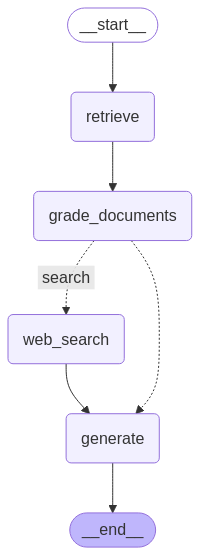

In [44]:
# View
display(Image(graph.get_graph().draw_mermaid_png()))
